# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/database.sqlite')

# filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [ ]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.sort_values('Time',inplace=True)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.<br /><br />Try it.  It's a great product.<br /><br /> ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I love these licorice.  Get licorice flavor--not just sugar with some flavor.  Very satisfying.


In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.Try it.  It's a great product. ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I love these licorice.  Get licorice flavor--not just sugar with some flavor.  Very satisfying.


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The orange and lemon peels make this tea very hippy Despite the initial oohing and ahing over the pretty blue flowers this is a regrettable purchase I was hoping for a stronger bergamot component than Twinings Earl Grey but instead I got something that seems very herbal Blech I disagree with the positive reviews 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:20<00:00, 2237.37it/s]


In [ ]:
preprocessed_reviews[1500]

'orange lemon peels make tea hippy despite initial oohing ahing pretty blue flowers regrettable purchase hoping stronger bergamot component twinings earl grey instead got something seems herbal blech disagree positive reviews'

In [ ]:
preprocessed_reviews_2=preprocessed_reviews[:5000]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8334397673606873), ('fantastic', 0.8117855191230774), ('good', 0.8057292103767395), ('terrific', 0.7908502221107483), ('excellent', 0.7661712169647217), ('perfect', 0.7591227293014526), ('amazing', 0.7575092315673828), ('wonderful', 0.7443681359291077), ('fabulous', 0.7128555774688721), ('decent', 0.6840022206306458)]
[('nastiest', 0.7342322468757629), ('greatest', 0.7111214995384216), ('best', 0.688611626625061), ('tastiest', 0.670167863368988), ('experienced', 0.6683140397071838), ('awful', 0.6506657004356384), ('closest', 0.6504844427108765), ('ive', 0.6423307657241821), ('neapolitan', 0.6139640212059021), ('disgusting', 0.609770655632019)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'screens', 'computer', 'nothing', 'bother', 'link', 'top', 'page']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V for 50k points

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [01:31<00:00, 505.60it/s]

46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [15:20<00:00, 50.06it/s]


##  Converting text into vectors using Avg W2V, TFIDF-W2V for 5k points

In [ ]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews_2:
    list_of_sentance.append(sentance.split())

In [ ]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('texture', 0.9952987432479858), ('real', 0.9939526319503784), ('good', 0.9922679662704468), ('cardboard', 0.9912286400794983), ('bar', 0.9912200570106506), ('guilt', 0.9911119341850281), ('chips', 0.9909942746162415), ('cookies', 0.9905180335044861), ('chewy', 0.9904530644416809), ('tasty', 0.9903009533882141)]
[('kitchen', 0.9993865489959717), ('hand', 0.9993712902069092), ('became', 0.9993464350700378), ('asked', 0.999336302280426), ('neither', 0.9993112683296204), ('read', 0.9992998242378235), ('life', 0.9992910623550415), ('finished', 0.9992786049842834), ('upon', 0.999266505241394), ('happened', 0.9992518424987793)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4020
sample words  ['really', 'good', 'idea', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'signs', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'computer', 'nothing', 'bother', 'link', 'top', 'page', 'buy', 'used', 'chewing', 'gum', 'lose', 'flavor', 'overnight']


In [ ]:
sent_vectors_2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_2.append(sent_vec)
print(len(sent_vectors_2))
print(len(sent_vectors_2[0]))

100%|██████████| 5000/5000 [00:05<00:00, 861.68it/s]

5000
50


In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews_2)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_2.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:35<00:00, 139.11it/s]


### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

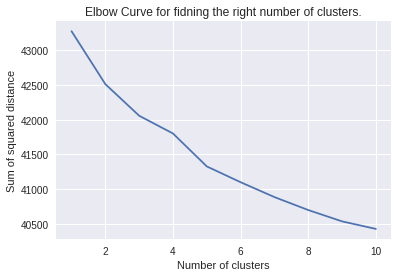

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

final_counts = normalize(final_counts)
n_clus = [1,2,3,4,5,6,7,8,9,10]
square_dist= []
for n in n_clus:
    kmeans = KMeans(n_clusters =n,init='k-means++').fit(final_counts)
    square_dist.append(kmeans.inertia_)
plt.plot(n_clus, square_dist)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.show()

                   Best number of clusters is 5.             

In [ ]:
kmeans = KMeans(n_clusters =5,init='k-means++').fit(final_counts)

In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))
print("\nNo. of reviews in Cluster 3 : ",len(cluster3))
print("\nNo. of reviews in Cluster 4 : ",len(cluster4))
print("\nNo. of reviews in Cluster 5 : ",len(cluster5))

No. of reviews in Cluster 1 :  3546

No. of reviews in Cluster 2 :  5149

No. of reviews in Cluster 3 :  19869

No. of reviews in Cluster 4 :  14532

No. of reviews in Cluster 5 :  2975


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

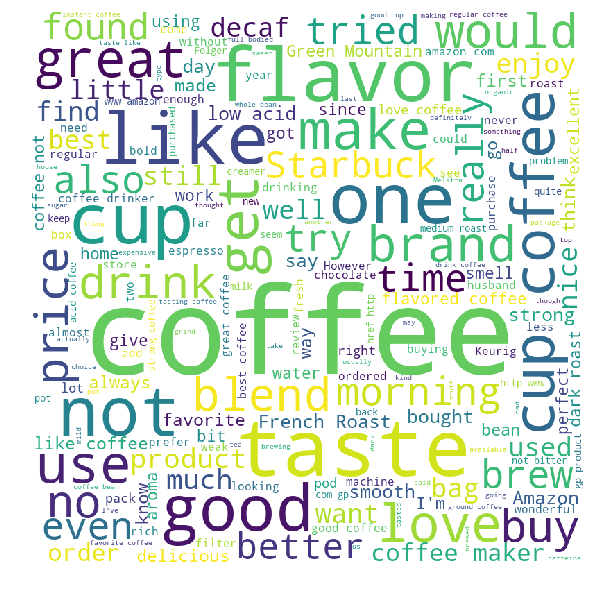

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


**1) Cluster 1 contains reviews related to cofee , cup , starbucks , etc.**

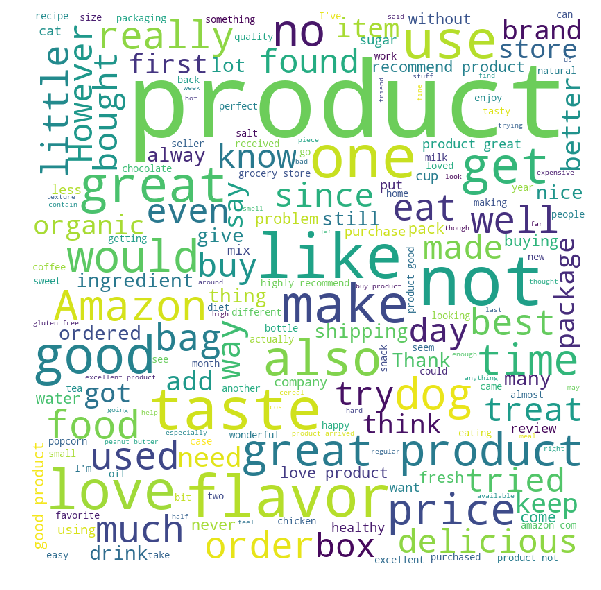

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) reviews in cluster 2 are not clear to identify**

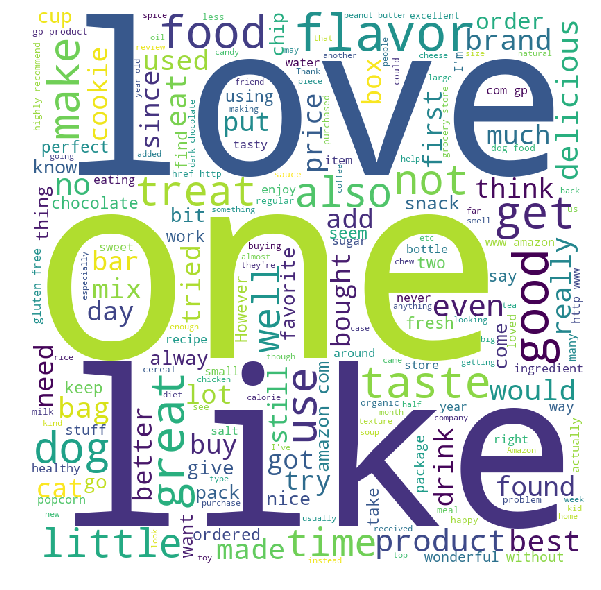

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster3))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**3) Cluster 3 contains reviews related to drinks,cookies,chocolate,etc**

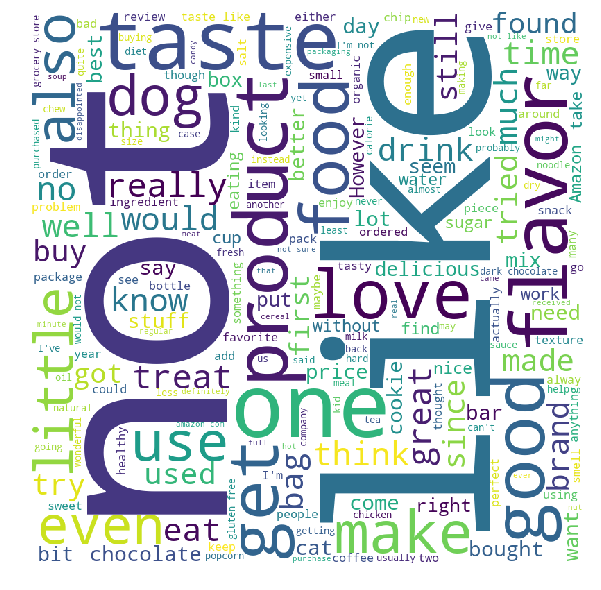

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster4))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**4) Cluster 4 is similar to cluster 3**

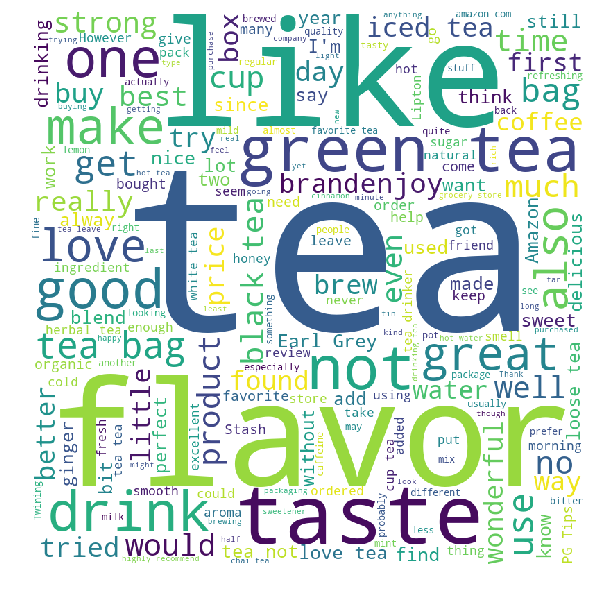

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster5))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**5) Cluster 5 contains reviews related to tea , ginger , cup , black tea , iced tea.**

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

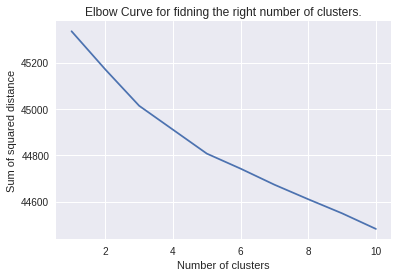

In [ ]:
# Please write all the code with proper documentation

from sklearn.cluster import KMeans

final_tf_idf = normalize(final_tf_idf)
n_clus = [1,2,3,5,6,7,8,9,10]
square_dist= []
for n in n_clus:
    kmeans = KMeans(n_clusters =n,init='k-means++').fit(final_tf_idf)
    square_dist.append(kmeans.inertia_)
plt.plot(n_clus, square_dist)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.show()


                    Best number of clusters is 5.

In [ ]:
kmeans = KMeans(n_clusters =5,init='k-means++').fit(final_tf_idf)

In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))
print("\nNo. of reviews in Cluster 3 : ",len(cluster3))
print("\nNo. of reviews in Cluster 4 : ",len(cluster4))
print("\nNo. of reviews in Cluster 5 : ",len(cluster5))

No. of reviews in Cluster 1 :  5315

No. of reviews in Cluster 2 :  3854

No. of reviews in Cluster 3 :  31777

No. of reviews in Cluster 4 :  3112

No. of reviews in Cluster 5 :  2013


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

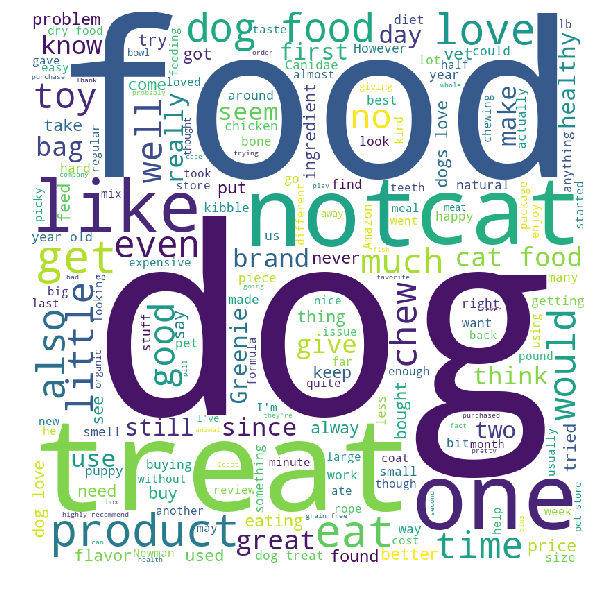

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**1) Cluster 1 contains reviews related to dog and cat food.**

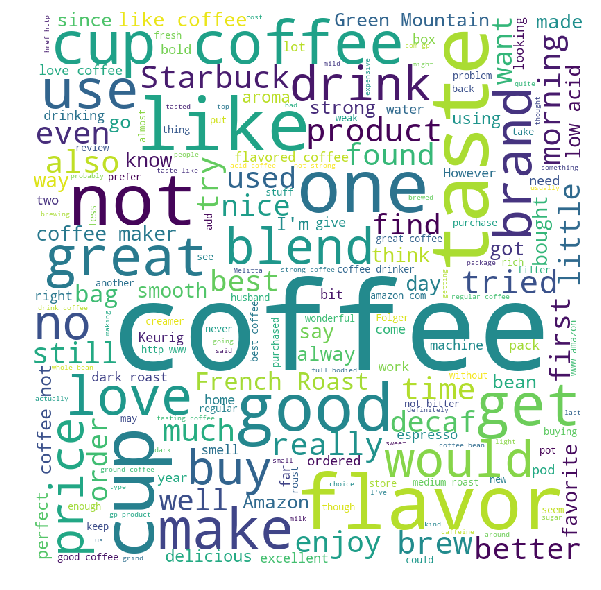

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) Cluster 2 consists of reviews related to coffee , cup , starbucks , etc.**

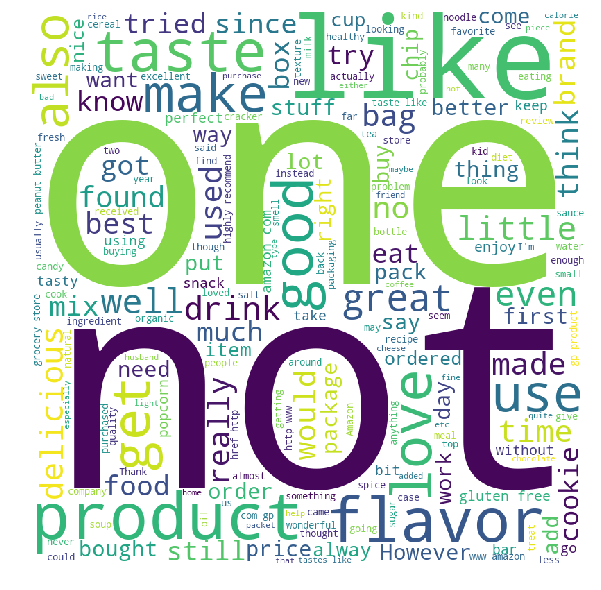

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster3))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**3) Cluster 3 contains reviews related to cookies , drinks , etc.**

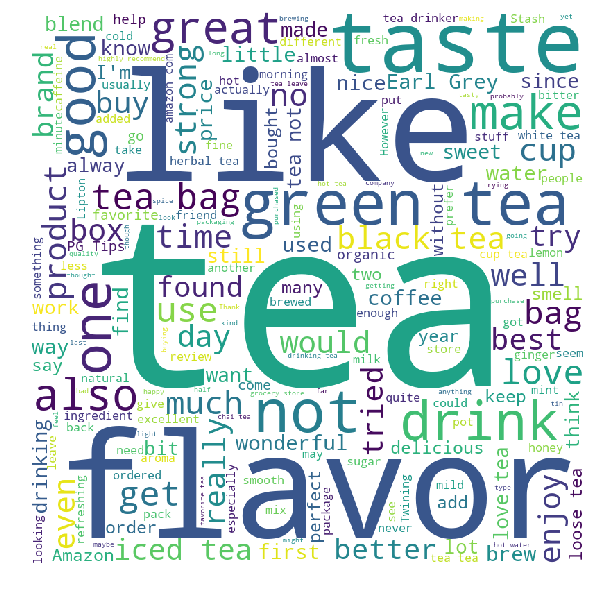

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster4))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**4) Cluster 4 conains reviews related to tea , iced tea , black tea , green tea , etc.**

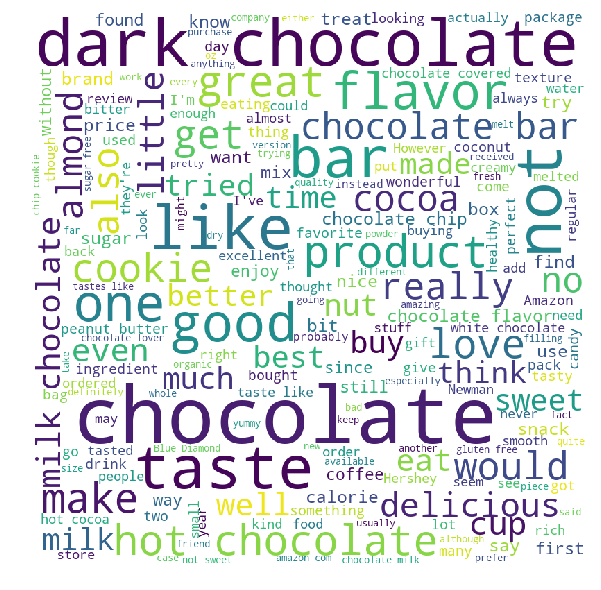

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster5))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**5) Cluster 5 contains reviews related to chocolate , milk , chocolate chips , chocolate bar , etc. **

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

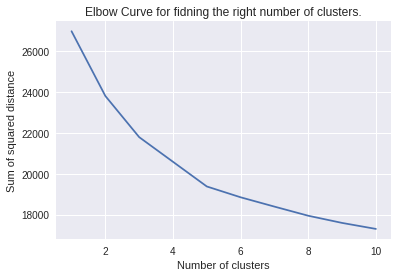

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

sent_vectors = normalize(sent_vectors)
n_clus = [1,2,3,5,6,7,8,9,10]
square_dist= []
for n in n_clus:
    kmeans = KMeans(n_clusters =n,init='k-means++').fit(sent_vectors)
    square_dist.append(kmeans.inertia_)
plt.plot(n_clus, square_dist)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.show()


                 Best number of clusters is 5

In [ ]:
kmeans = KMeans(n_clusters =5,init='k-means++').fit(sent_vectors)

In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))
print("\nNo. of reviews in Cluster 3 : ",len(cluster3))
print("\nNo. of reviews in Cluster 4 : ",len(cluster4))
print("\nNo. of reviews in Cluster 5 : ",len(cluster5))

No. of reviews in Cluster 1 :  7865

No. of reviews in Cluster 2 :  11929

No. of reviews in Cluster 3 :  6862

No. of reviews in Cluster 4 :  10710

No. of reviews in Cluster 5 :  8705


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

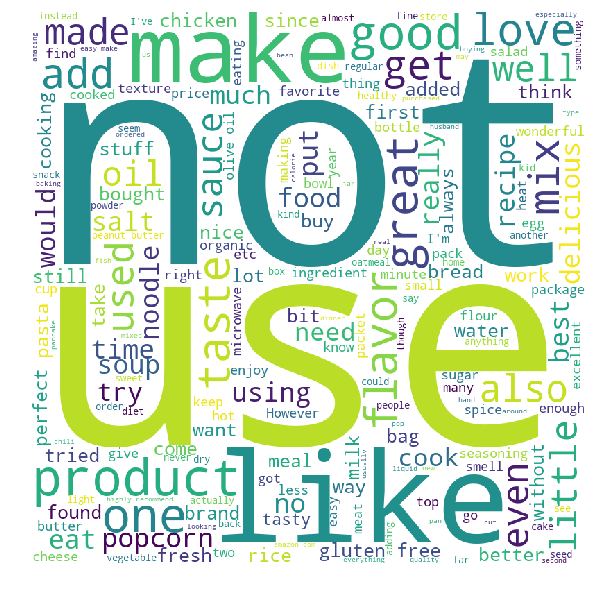

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**1) Cluster 1 contains reviews related to noodles , popcorn , chicken , etc.**

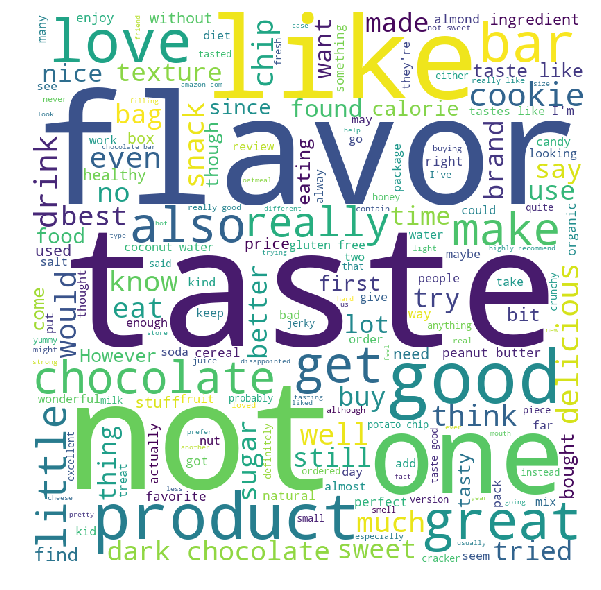

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) Cluster 2 contains reviews related to chocolate ,  cookies , snacks , etc.**

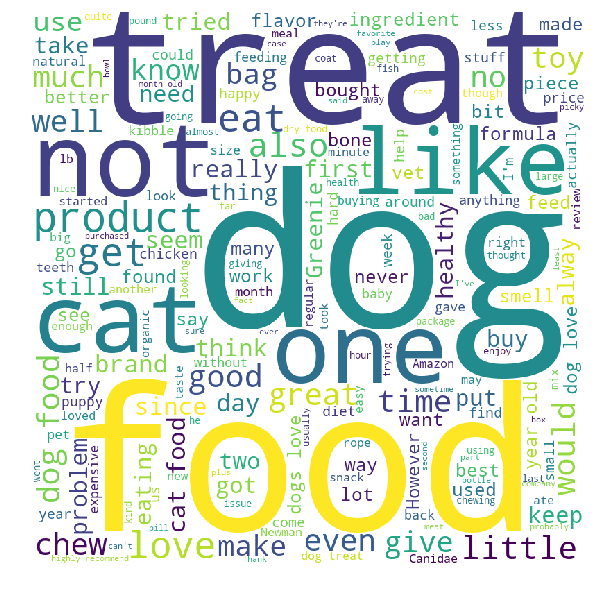

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster3))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**3) Cluster 3 contains reviews related to dog and cat food.**

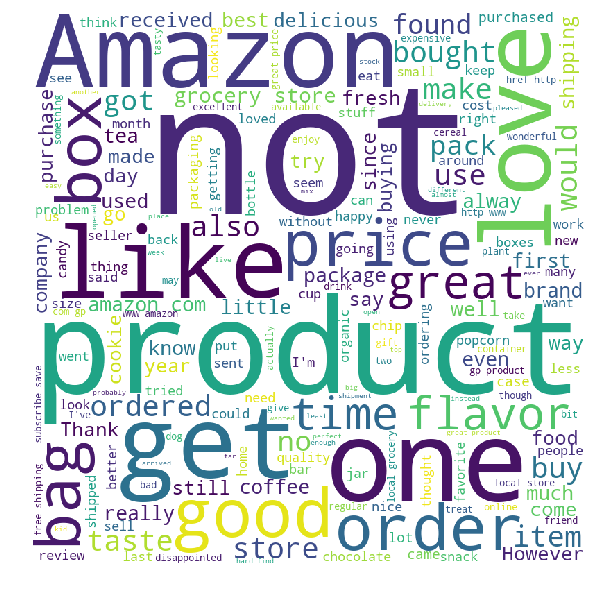

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster4))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**4) Cluster 4 contains reviews related to coffee , candy , etc.**

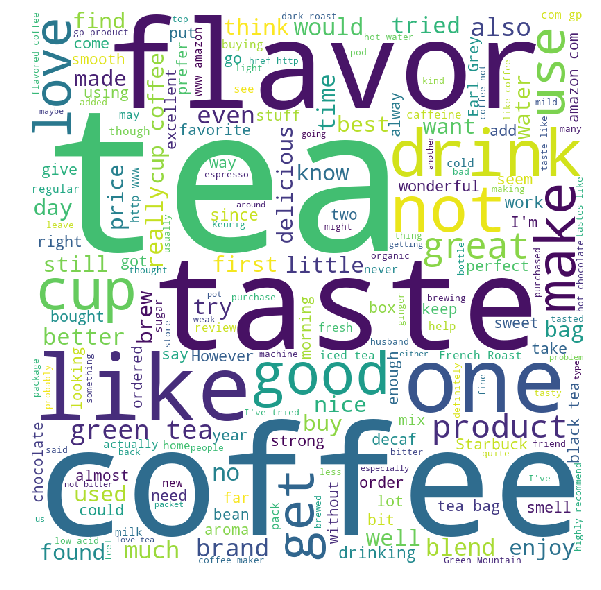

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster5))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**5) Cluster 5 contains reviews related to coffee , tea ,  green tea , etc.**

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

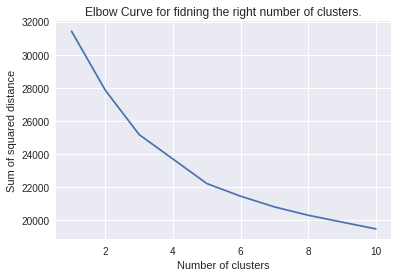

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
tfidf_sent_vectors = normalize(tfidf_sent_vectors)
n_clus = [1,2,3,5,6,7,8,9,10]
square_dist= []
for n in n_clus:
    kmeans = KMeans(n_clusters =n,init='k-means++').fit(tfidf_sent_vectors)
    square_dist.append(kmeans.inertia_)
plt.plot(n_clus, square_dist)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.show()


                 Best number of Clusters is 5.

In [ ]:
kmeans = KMeans(n_clusters =5,init='k-means++').fit(tfidf_sent_vectors)

In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))
print("\nNo. of reviews in Cluster 3 : ",len(cluster3))
print("\nNo. of reviews in Cluster 4 : ",len(cluster4))
print("\nNo. of reviews in Cluster 5 : ",len(cluster5))

No. of reviews in Cluster 1 :  8110

No. of reviews in Cluster 2 :  8687

No. of reviews in Cluster 3 :  12086

No. of reviews in Cluster 4 :  10279

No. of reviews in Cluster 5 :  6909


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

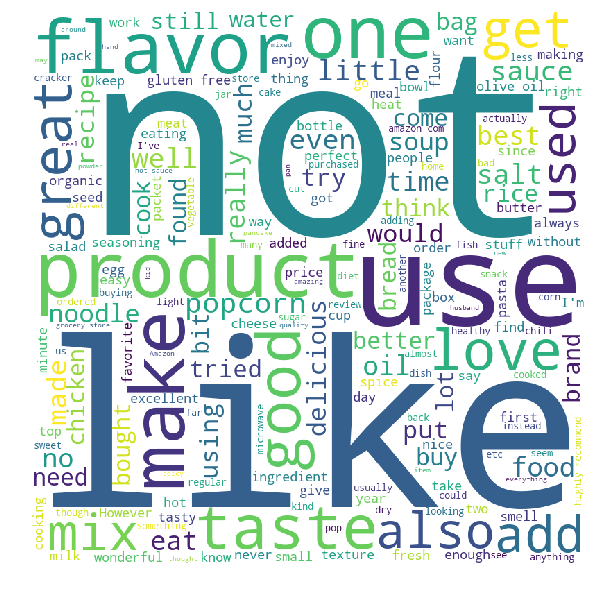

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**1) Cluster 1 contains reviews related to soup , rice , salt , noodles , popcorn , etc..**

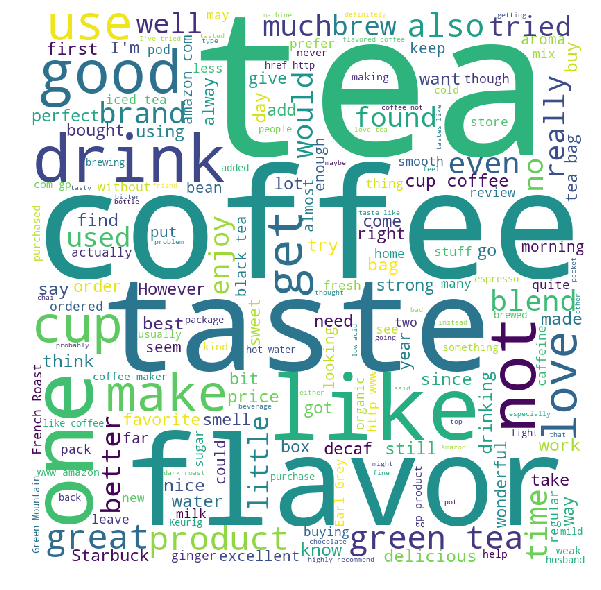

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) Cluster 2 contains reviews related to coffee , tea , green tea , starbucks , etc.**

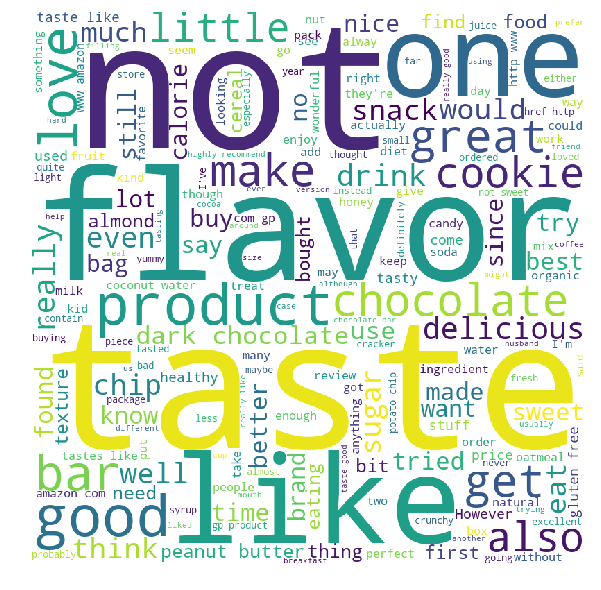

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster3))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**3) Cluster 3 contains reviews related to chocolate , cookies , dark chocolate , etc.**

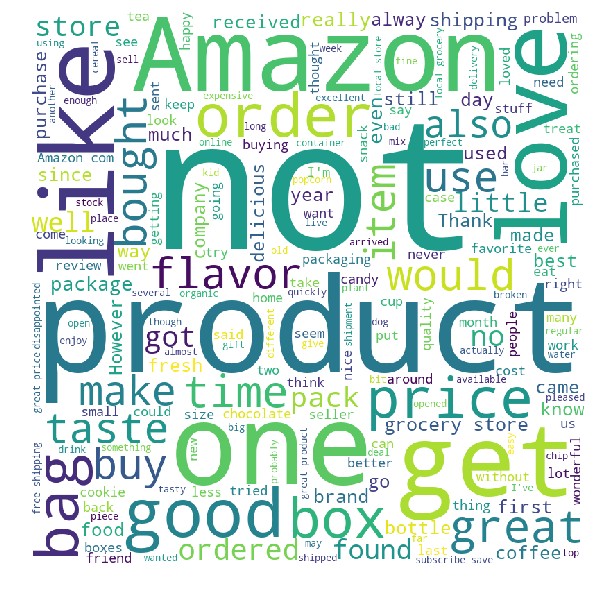

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster4))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**4) Cluster 4 contains reviews related to candy , cookies , coffee , etc.**

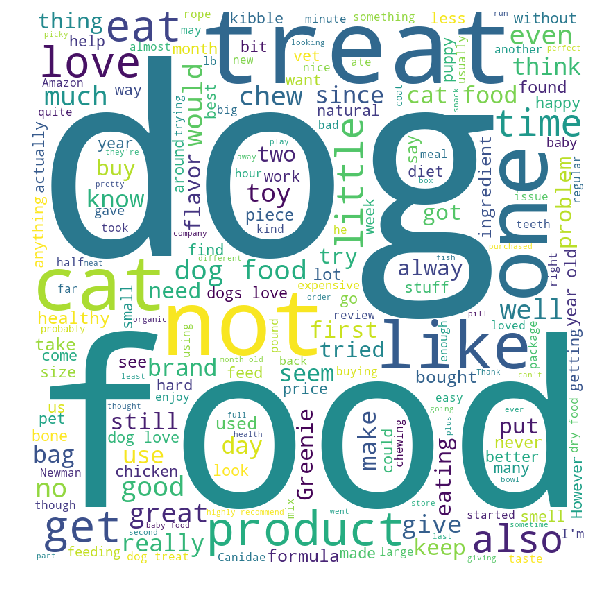

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster5))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**5) Cluster 5 contains reviews related to dog and cat food.**

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

**I have tried various values of n_clusters .The best value is 5 for 5K points.**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
sent_vectors_2 = normalize(sent_vectors_2)
agg=AgglomerativeClustering(n_clusters=2).fit(sent_vectors_2)

In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []

for i in range(agg.labels_.shape[0]):
    if agg.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif agg.labels_[i] == 1:
        cluster2.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))

No. of reviews in Cluster 1 :  4976

No. of reviews in Cluster 2 :  24


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

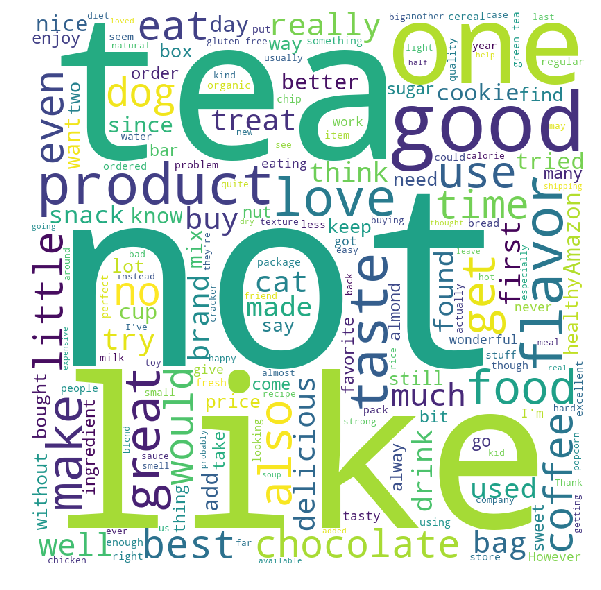

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**1) Cluster 1 contains reviews related to tea , coffee , chocolate , snacks , etc.**

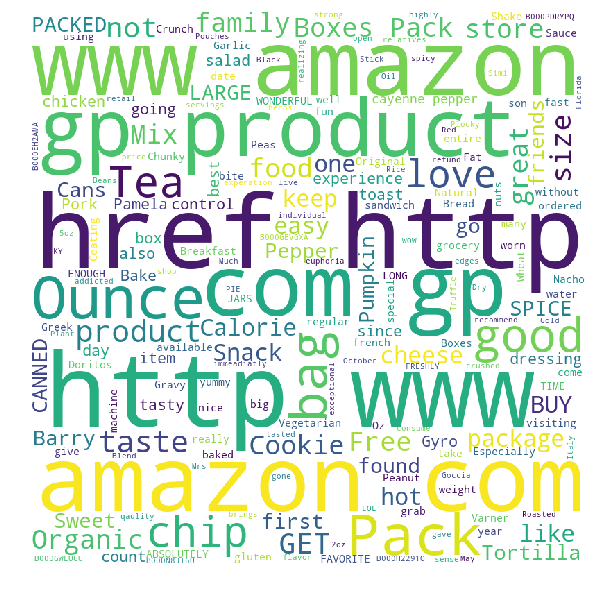

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) Cluster 2 is not clear to identify the type of reviews but it mostly contains chips , snacks , sandwich , etc.**

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
tfidf_sent_vectors_2 = normalize(tfidf_sent_vectors_2)
agg=AgglomerativeClustering(n_clusters=2).fit(tfidf_sent_vectors_2)

In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []

for i in range(agg.labels_.shape[0]):
    if agg.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif agg.labels_[i] == 1:
        cluster2.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))

No. of reviews in Cluster 1 :  345

No. of reviews in Cluster 2 :  4655


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

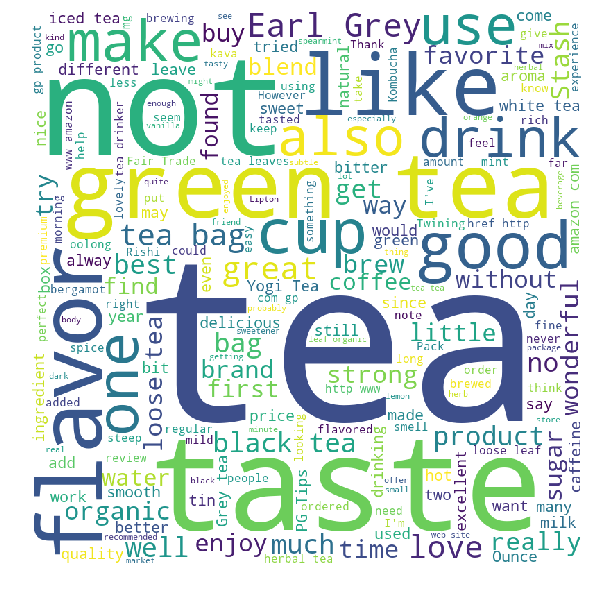

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**1) Cluster 1 contains reviews related to tea , black tea , coffee , iced tea , etc.**

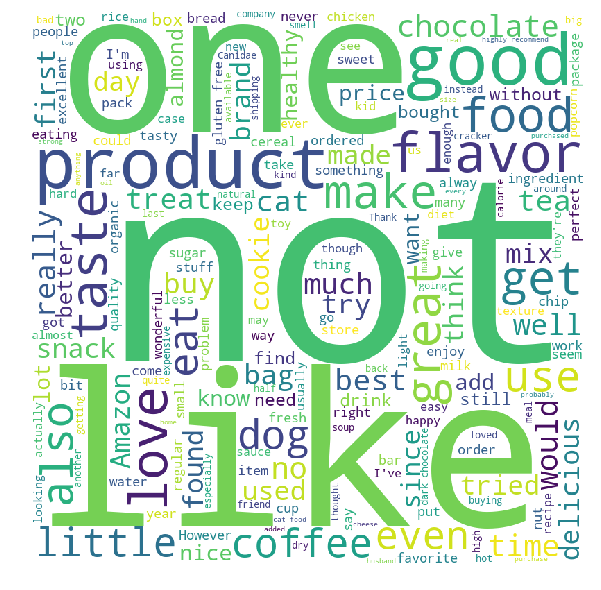

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) Cluster 2 contains reviews related to chocolate , bread , coffee , almond , etc.**

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

I have applied DBSCAN on 5K points.

**Function to obtain distance.**

In [ ]:
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

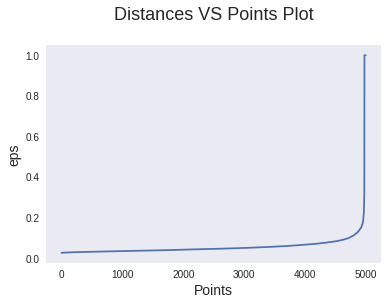

In [ ]:
sent_vectors_2=np.array(sent_vectors_2)
min_points = 2*sent_vectors_2.shape[1]
distances = n_neighbour(sent_vectors_2,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(sent_vectors_2.shape[0])]

plt.plot(points, sorted_distance)
plt.xlabel('Points',size=14)
plt.ylabel('eps',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()


Best value of Epsilon is 0.14 because after that there is sharp rise in the value of distance

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize

sent_vectors_2 = normalize(sent_vectors_2)
db=DBSCAN(eps=0.14).fit(sent_vectors_2)
print(len(set(db.labels_)))

2


In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []

for i in range(db.labels_.shape[0]):
    if db.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif db.labels_[i] == 1:
        cluster2.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))

No. of reviews in Cluster 1 :  4976

No. of reviews in Cluster 2 :  24


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

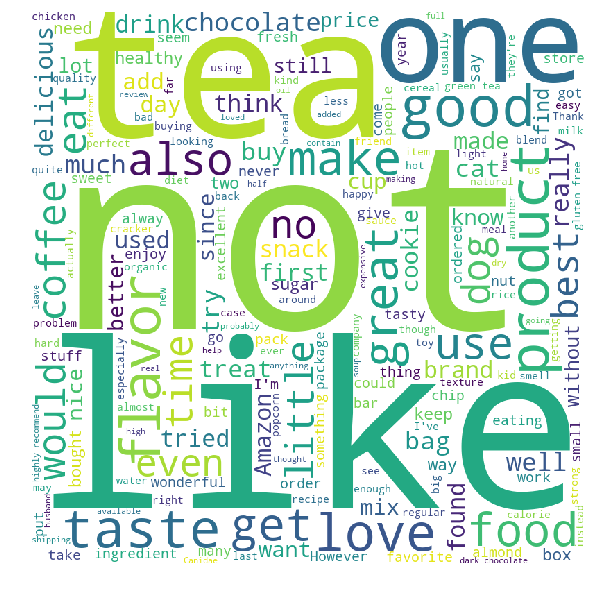

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**1) Cluster 1 contains reviews related to tea , coffee , snacks , chocolate , etc.**

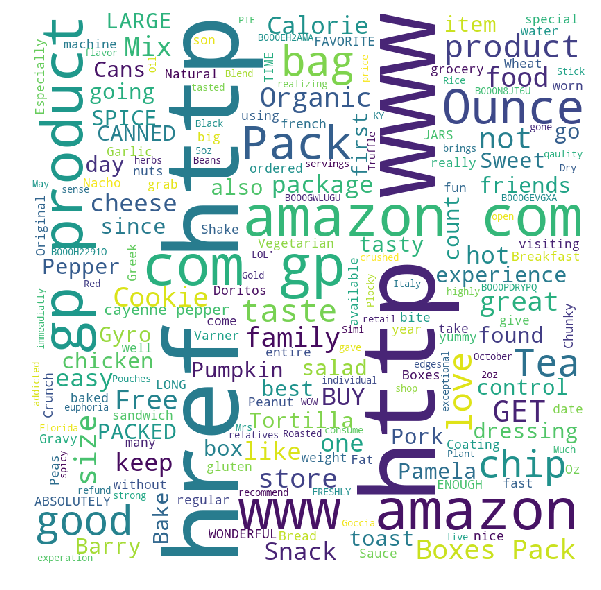

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) Cluster 2 contains reviews related to cookies , chips , cheese , etc.**

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

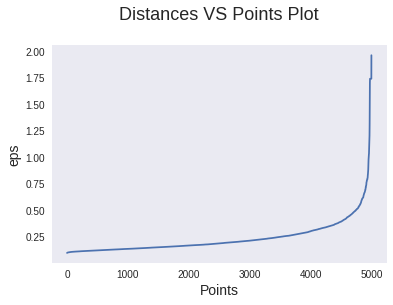

In [ ]:
tfidf_sent_vectors_2=np.array(tfidf_sent_vectors_2)
min_points = 2*tfidf_sent_vectors_2.shape[1]
distances = n_neighbour(tfidf_sent_vectors_2,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(tfidf_sent_vectors_2.shape[0])]

plt.plot(points, sorted_distance)
plt.xlabel('Points',size=14)
plt.ylabel('eps',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()


Best value of Epsilon is 0.5 because after that there is sharp rise in the value of distance



In [ ]:
tfidf_sent_vectors_2 = normalize(tfidf_sent_vectors_2)
db=DBSCAN(eps=0.5).fit(tfidf_sent_vectors_2)
print(len(set(db.labels_)))

2


In [ ]:
reviews = final['Text'].values
cluster1 = []
cluster2 = []

for i in range(db.labels_.shape[0]):
    if db.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif db.labels_[i] == 1:
        cluster2.append(reviews[i])

print("No. of reviews in Cluster 1 : ",len(cluster1))
print("\nNo. of reviews in Cluster 2 : ",len(cluster2))

No. of reviews in Cluster 1 :  4976

No. of reviews in Cluster 2 :  24


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

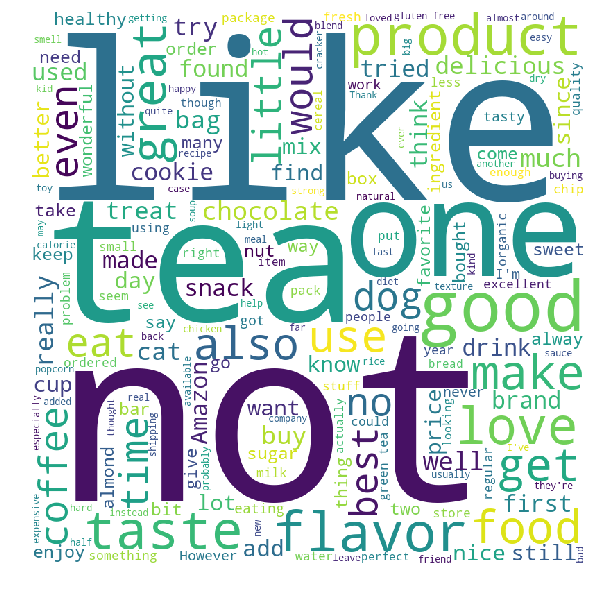

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster1))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**1) Cluster 2 contains reviews related to tea , coffee , snacks , etc.**

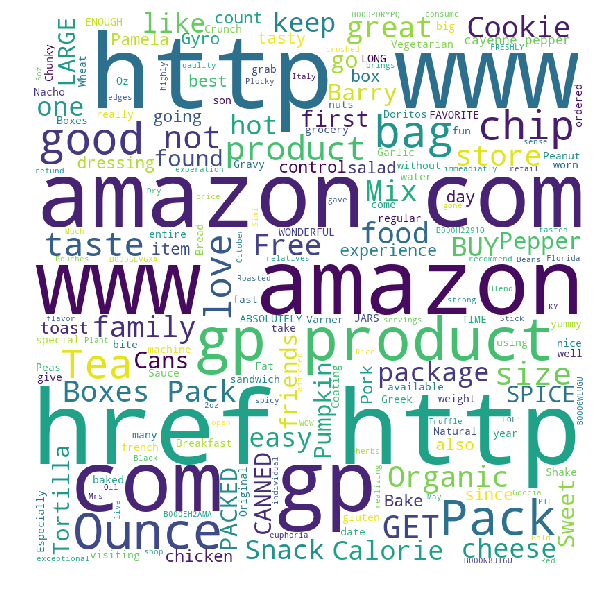

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(cluster2))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**2) Cluster 2 contains reviews related to chips ,cheese , cookies , etc .**

# [6] Conclusions

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "MODEL", "BOW", "TFIDF","AVG W2V","TFIDF W2V"]
x.add_row(["1", "K Means", "n_cluster : 5", "n_cluster : 5","n_cluster : 5","n_cluster : 5"])
x.add_row(["2", "Agglomerative", "-", "-","n_cluster : 2","n_cluster : 2"])
x.add_row(["3", "DBSCAN", "-", "-","eps : 0.14","eps : 0.5"])

print(x)

+-------+---------------+---------------+---------------+---------------+---------------+
| S.NO. |     MODEL     |      BOW      |     TFIDF     |    AVG W2V    |   TFIDF W2V   |
+-------+---------------+---------------+---------------+---------------+---------------+
|   1   |    K Means    | n_cluster : 5 | n_cluster : 5 | n_cluster : 5 | n_cluster : 5 |
|   2   | Agglomerative |       -       |       -       | n_cluster : 2 | n_cluster : 2 |
|   3   |     DBSCAN    |       -       |       -       |   eps : 0.14  |   eps : 0.5   |
+-------+---------------+---------------+---------------+---------------+---------------+
